In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import argparse
import time
from typing import Tuple, Optional, Dict
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random

from env import MazeEnv
from agent_basic import MyAgents

In [2]:
import os
os.getcwd()
checkpoint_dir = 'checkpoints_qlearn'
os.makedirs(checkpoint_dir, exist_ok=True)

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [16]:
def simulation_config(config_path: str, new_agent: bool = True) -> Tuple[MazeEnv, Optional[MyAgents], Dict]:
    """
    Configure the environment and optionally an agent using a JSON configuration file.

    Args:
        config_path (str): Path to the configuration JSON file.
        new_agent (bool): Whether to initialize the agent. Defaults to True.

    Returns:
        Tuple[MazeEnv, Optional[MyAgent], Dict]: Configured environment, agent (if new), and the configuration dictionary.
    """
    
    # Read config
    with open(config_path, 'r') as config_file:
        config = json.load(config_file)

    # Env configuration
    env = MazeEnv(
        size=config.get('grid_size'),                               # Grid size
        walls_proportion=config.get('walls_proportion'),            # Walls proportion in the grid
        num_dynamic_obstacles=config.get('num_dynamic_obstacles'),  # Number of dynamic obstacles
        num_agents=config.get('num_agents'),                        # Number of agents
        communication_range=config.get('communication_range'),      # Maximum distance for agent communications
        max_lidar_dist_main=config.get('max_lidar_dist_main'),      # Maximum distance for main LIDAR scan
        max_lidar_dist_second=config.get('max_lidar_dist_second'),  # Maximum distance for secondary LIDAR scan
        max_episode_steps=config.get('max_episode_steps'),          # Number of steps before episode termination
        render_mode=config.get('render_mode', None),
        seed=config.get('seed', None)                               # Seed for reproducibility
    )

    # Agent configuration
    agents = [MyAgents(state_dim=11,action_dim=env.action_space.n, device=device, lr = 0.001) if new_agent else None  for _ in range(config.get('num_agents'))]

    return env, agents, config

In [18]:
# Environment and agent configuration
env, agents, config = simulation_config('config.json')
max_episodes = config.get('max_episodes')
num_agents = config.get('num_agents')

# Metrics to follow the performance
all_rewards = []
total_reward = 0
episode_count = 0
epsilon_history = []
loss_history = np.zeros((num_agents, max_episodes)) 
# Initial reset of the environment
#state, info = env.reset()
time.sleep(1)
try:
    while episode_count < max_episodes:
        states, info = env.reset()
        done = False
        epsilon_mean = 0
        for agent in agents:
            epsilon_mean += agent.epsilon
        epsilon_mean /= len(agents)
        epsilon_history.append(epsilon_mean)
        while not done:
            # Determine agents actions
            
            actions = [agents[i].get_action(states[i]) for i in range(num_agents)]

            # Execution of a simulation step
            next_state, rewards, terminated, truncated, info = env.step(actions)
            total_reward += np.sum(rewards)

            for i, agent in enumerate(agents):
                # Store the transition in the replay buffer
                agent.replay_buffer.append((states[i], actions[i], rewards[i], next_state[i], terminated))
                # Update agent policy
                loss = agent.update_policy()
                loss_history[i, episode_count] = loss
                #update state
                states[i] = next_state[i]
            done = terminated or truncated
        
        #update espilon
        if episode_count > 50:
          for agent in agents:
            agent.epsilon = max(agent.epsilon_min, agent.epsilon * 0.995)
            
        # Update the target network
        if episode_count % 10 == 0:
          for agent in agents:
              agent.update_target_network()
        
        if episode_count % 100 == 0:
            for i, agent in enumerate(agents):
                torch.save(agent.q_network.state_dict(), f"{checkpoint_dir}/agent_{i}_episode_{episode_count}.pth")
        # Display of the step information
        print(f"\rEpisode {episode_count + 1}, Step {info['current_step']}, "
                f"Reward: {total_reward:.2f}, "
                f"Evacuated: {len(info['evacuated_agents'])}, "
                f"Deactivated: {len(info['deactivated_agents'])}", end='')
        
        # Pause
        #time.sleep(1)
        # If the episode is terminated
        if terminated or truncated:
            print("\r")
            episode_count += 1
            all_rewards.append(total_reward)
            total_reward = 0
            
            if episode_count < max_episodes:
                state, info = env.reset()

except KeyboardInterrupt:
    print("\nSimulation interrupted by the user")

finally:
    env.close()


Episode 1, Step 41, Reward: -935.28, Evacuated: 0, Deactivated: 2
Episode 2, Step 15, Reward: -515.49, Evacuated: 0, Deactivated: 2
Episode 3, Step 34, Reward: -643.47, Evacuated: 0, Deactivated: 2
Episode 4, Step 29, Reward: -602.60, Evacuated: 0, Deactivated: 2
Episode 5, Step 36, Reward: -777.61, Evacuated: 0, Deactivated: 2
Episode 6, Step 32, Reward: -798.52, Evacuated: 0, Deactivated: 2
Episode 7, Step 96, Reward: -1376.03, Evacuated: 0, Deactivated: 2
Episode 8, Step 9, Reward: -506.02, Evacuated: 0, Deactivated: 2
Episode 9, Step 87, Reward: -1106.58, Evacuated: 0, Deactivated: 2
Episode 10, Step 58, Reward: -826.47, Evacuated: 0, Deactivated: 2
Episode 11, Step 12, Reward: -524.59, Evacuated: 0, Deactivated: 2
Episode 12, Step 39, Reward: -798.05, Evacuated: 0, Deactivated: 2
Episode 13, Step 11, Reward: -498.30, Evacuated: 0, Deactivated: 2
Episode 14, Step 9, Reward: -497.85, Evacuated: 0, Deactivated: 2
Episode 15, Step 91, Reward: -1320.16, Evacuated: 0, Deactivated: 2
Epi

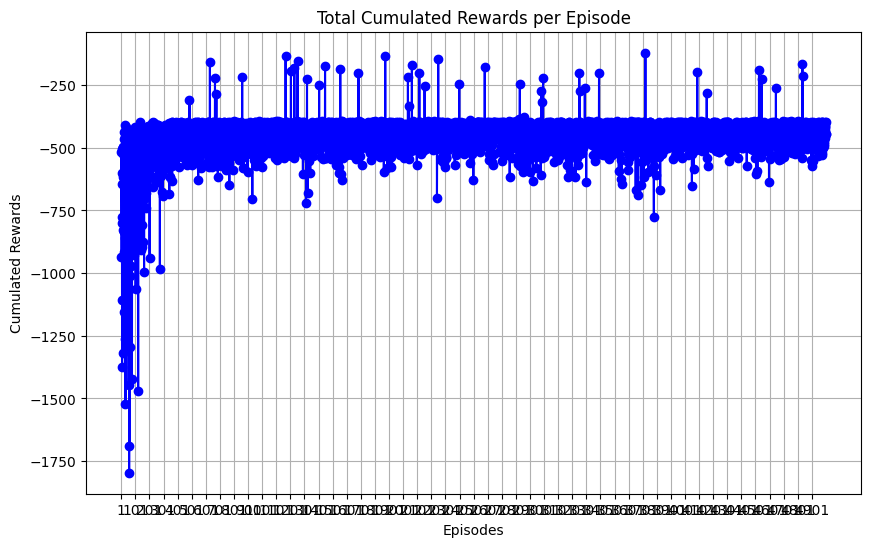

In [19]:
import simulate

simulate.plot_cumulated_rewards(all_rewards)

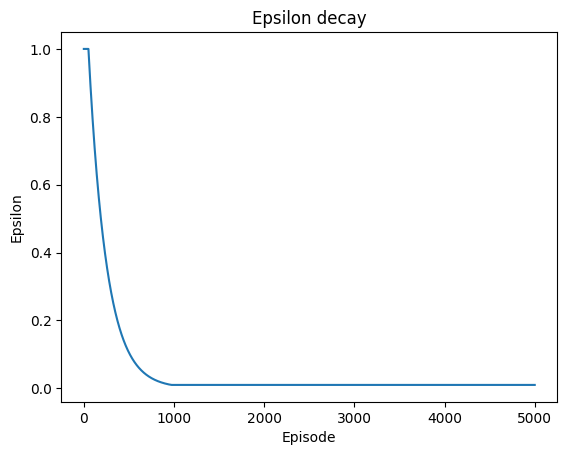

In [20]:
#plot espilon
plt.plot(epsilon_history)
plt.title("Epsilon decay")
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.show()

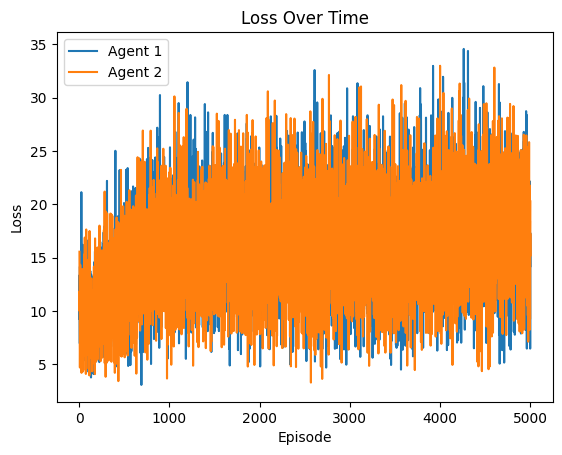

In [21]:
#plot loss
# filter null values
plot_loss = [[],[]]
for i in range(num_agents):
    plot_loss[i] = loss_history[i][loss_history[i] != 0]
# plot
for i in range(num_agents):
    plt.plot(plot_loss[i], label=f"Agent {i+1}")
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.title("Loss Over Time")
plt.legend()
plt.show()

In [11]:
def evaluate(configs_paths: list, trained_agent: MyAgents, num_episodes: int = 10) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Evaluate a trained agent on multiple configurations, calculate metrics, and visualize results.

    Args:
        config_path (list): List of paths to the configuration JSON files.
        trained_agent (MyAgent): A pre-trained agent to evaluate.
        num_episodes (int): Number of episodes to run for evaluation per configuration. Defaults to 10.

    Returns:
        pd.DataFrame: A DataFrame containing evaluation metrics for each episode and configuration.
    """

    # Evaluation results
    all_results = pd.DataFrame()

    for config_path in configs_paths:
        print(f"\n--- Evaluating Configuration: {config_path} ---")

        # Environment configuration
        env, _, config = simulation_config(config_path, new_agent=False)

        # Metrics to follow the performance
        metrics = []
        total_reward = 0
        episode_count = 0
        
        # Initial reset of the environment
        state, info = env.reset()
        time.sleep(1) 
   
        # Run evaluation for the specified number of episodes
        try:
            while episode_count < num_episodes:
                # Determine agents actions
                actions = trained_agent.get_action(state[0])

                # Execution of a simulation step
                state, rewards, terminated, truncated, info = env.step(actions)
                total_reward += np.sum(rewards)

                # Display of the step information
                print(f"\rEpisode {episode_count + 1}/{num_episodes}, Step {info['current_step']}, "
                    f"Reward: {total_reward:.2f}, "
                    f"Evacuated: {len(info['evacuated_agents'])}, "
                    f"Deactivated: {len(info['deactivated_agents'])}", end='')
            
                # Pause
                #time.sleep(1)

                # If the episode is terminated
                if terminated or truncated:
                    print("\r")
                    # Save metrics
                    metrics.append({
                        "config_path": config_path,
                        "episode": episode_count + 1,
                        "steps": info['current_step'],
                        "reward": total_reward,
                        "evacuated": len(info['evacuated_agents']),
                        "deactivated": len(info['deactivated_agents'])
                    })

                    episode_count += 1
                    total_reward = 0

                    if episode_count < num_episodes:
                        state, info = env.reset()
        
        except KeyboardInterrupt:
            print("\nSimulation interrupted by the user")
        
        finally:
            env.close()

        # Convert the current configuration's metrics to a DataFrame
        config_results = pd.DataFrame(metrics)
        all_results = pd.concat([all_results, config_results], ignore_index=True)
    
    env.close()

    all_results.to_csv('all_results.csv', index=False)

    return all_results

In [15]:
# Load the trained agent
agent = [MyAgents(state_dim=11,action_dim=env.action_space.n, device=device, lr = 0.0001) for i in range(2)]
for i in range(2):
    agent[i].q_network.load_state_dict(torch.load(f"{checkpoint_dir}/agent_{i}_episode_4900.pth"))
    agent[i].epsilon = 0
all_results = evaluate(configs_paths=['config.json'], trained_agent=agent)


--- Evaluating Configuration: config.json ---


AttributeError: 'list' object has no attribute 'get_action'